In [2]:
import torch
import gc
# Force garbage collection
gc.collect()
# Clear CUDA cache
torch.cuda.empty_cache()

# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")

CUDA available: True


In [3]:
# Number of GPUs
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    
    # GPU name
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    
    # Current GPU device
    print(f"Current GPU: {torch.cuda.current_device()}")

# Get current GPU memory usage
if torch.cuda.is_available():
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Cached GPU memory: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")
    
    # Get maximum GPU memory usage
    print(f"Max allocated GPU memory: {torch.cuda.max_memory_allocated(0) / 1024**2:.2f} MB")

Number of GPUs: 1
GPU name: NVIDIA GeForce RTX 4090
Current GPU: 0
Allocated GPU memory: 0.00 MB
Cached GPU memory: 0.00 MB
Max allocated GPU memory: 0.00 MB


In [1]:
# path: improved_rag_system.py

import faiss
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from typing import List, Dict, Union, Any
from transformers import pipeline
import re
import json
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class EmergencyResponseRAG:
    def __init__(self, index_path="document_faiss.index", dataset_path="rest_dataset_with_document.csv", 
                 embedding_model_name='all-mpnet-base-v2', llm_model_name="meta-llama/Llama-2-7b-chat-hf", 
                 device=0):
        logger.info("Initializing Emergency Response RAG system...")
        
        # 1. Load FAISS Index
        self.index = faiss.read_index(index_path)
        logger.info(f"Loaded FAISS index from {index_path}")
        
        # 2. Load Dataset
        self.df = pd.read_csv(dataset_path)
        logger.info(f"Loaded dataset from {dataset_path} with {len(self.df)} records")
        
        # 3. Load Embedding Model
        self.embedding_model = SentenceTransformer(embedding_model_name)
        logger.info(f"Loaded embedding model: {embedding_model_name}")
        
        # 4. Load LLM Model
        self.llm_model_name = llm_model_name
        self.llm_pipeline = pipeline(
            "text-generation",
            model=llm_model_name,
            tokenizer=llm_model_name,
            max_length=2048,
            temperature=0.2,
            device=device  # 0 for first GPU; use -1 if running on CPU
        )
        logger.info(f"Loaded LLM: {llm_model_name}")
    
    def clean_tweet(self, text: str) -> str:
        """Clean and normalize the text of a tweet"""
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        text = re.sub(r'\@\w+', '', text)
        text = re.sub(r'#', '', text)
        text = text.encode('ascii', 'ignore').decode('ascii')
        text = text.lower()
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def embed_text(self, text: str) -> np.ndarray:
        """Create an embedding for the input text"""
        embedding = self.embedding_model.encode([text], convert_to_numpy=True)
        return embedding
    
    def retrieve_documents(self, query: str, k: int = 3) -> List[str]:
        """Retrieve top-k relevant documents for the query"""
        query_vector = self.embed_text(query)
        distances, indices = self.index.search(query_vector, k)
        
        # Check if any valid indices were found
        if len(indices[0]) == 0 or (indices[0][0] == -1):
            logger.warning("No relevant documents found in the index")
            return ["No relevant incident reports available."]
            
        retrieved_docs = self.df.iloc[indices[0]]['document'].tolist()
        logger.info(f"Retrieved {len(retrieved_docs)} documents")
        return retrieved_docs
    
    def build_combined_prompt(self, tweet_text: str, retrieved_docs: List[str]) -> str:
        """Build a prompt for LLaMA-2 that follows its expected format"""
        prompt = """<s>[INST] <<SYS>>
You are an emergency response assistant that analyzes social media posts about disasters.
<</SYS>>

Given the following tweet and related incident reports, analyze the emergency situation and respond with a classification:

Tweet:
""" + tweet_text + "\n\nRelated Incident Reports:\n"

        for idx, doc in enumerate(retrieved_docs, 1):
            prompt += f"Incident {idx}: {doc}\n"

        prompt += """
Analyze the tweet and determine:
1. Disaster Type Classification: wildfire, earthquake, flood, hurricane, or other
2. Distress Detection: 'distress' if someone needs urgent help, otherwise 'not distress'
3. Location Extraction: most specific geographic location mentioned or 'unknown'
4. Action Suggestion: evacuation, medical aid, fire suppression, rescue, resource delivery, or monitor only

Return your analysis in this exact JSON format:
{
  "disaster_type": "selected disaster type",
  "distress": "distress or not distress",
  "location_info": "location name or unknown",
  "action": "selected action"
}
[/INST]"""

        return prompt
    
    def extract_json_from_response(self, response: str) -> Dict[str, Any]:
        """Extract and parse the JSON portion from the LLM response"""
        # First try to find a well-formed JSON object using regex
        json_pattern = r'{\s*"disaster_type"\s*:.*?"action"\s*:.*?}'
        json_match = re.search(json_pattern, response, re.DOTALL)
        
        if json_match:
            try:
                # Clean up the JSON string (remove any trailing commas)
                json_str = re.sub(r',\s*}', '}', json_match.group(0))
                # Parse to ensure valid JSON
                parsed_json = json.loads(json_str)
                return parsed_json
            except json.JSONDecodeError as e:
                logger.error(f"JSON parsing error: {e}")
                
        # If regex approach failed, try a more flexible approach
        try:
            # Look for the beginning of json content
            start_idx = response.find('{')
            end_idx = response.rfind('}') + 1
            
            if start_idx != -1 and end_idx > start_idx:
                json_str = response[start_idx:end_idx]
                # Handle potential line breaks and formatting issues
                json_str = re.sub(r'[\n\r\t]', ' ', json_str)
                json_str = re.sub(r',\s*}', '}', json_str)
                
                return json.loads(json_str)
        except (json.JSONDecodeError, ValueError) as e:
            logger.error(f"Secondary JSON parsing error: {e}")
        
        # If all parsing attempts fail, return a structured error
        logger.error(f"Failed to extract JSON from response: {response[:100]}...")
        return {
            "error": "Could not parse response",
            "disaster_type": "unknown",
            "distress": "unknown",
            "location_info": "unknown",
            "action": "unknown"
        }
    
    def call_llm(self, prompt: str) -> Dict[str, Any]:
        """Call the LLM and parse its response to extract the JSON output"""
        try:
            outputs = self.llm_pipeline(prompt, max_new_tokens=800)
            full_response = outputs[0]['generated_text']
            
            # Extract just the model's new response (after the prompt)
            response = full_response[len(prompt):] if full_response.startswith(prompt) else full_response
            
            # Extract and parse the JSON
            result = self.extract_json_from_response(response)
            
            # Validate expected fields
            expected_fields = ["disaster_type", "distress", "location_info", "action"]
            for field in expected_fields:
                if field not in result:
                    result[field] = "unknown"
                    
            return result
            
        except Exception as e:
            logger.error(f"Error calling LLM: {e}")
            return {
                "error": str(e),
                "disaster_type": "unknown",
                "distress": "unknown",
                "location_info": "unknown",
                "action": "unknown"
            }
    
    def process_tweet(self, tweet_text: str) -> Dict[str, Any]:
        """Process a tweet through the full RAG pipeline"""
        try:
            # 1. Clean the tweet
            cleaned_tweet = self.clean_tweet(tweet_text)
            logger.info(f"Cleaned tweet: {cleaned_tweet}")
            
            # 2. Retrieve relevant documents
            retrieved_docs = self.retrieve_documents(cleaned_tweet, k=3)
            
            # 3. Build the prompt
            prompt = self.build_combined_prompt(cleaned_tweet, retrieved_docs)
            
            # 4. Get LLM response
            result = self.call_llm(prompt)
            
            # 5. Return the final result
            return {
                "input_tweet": tweet_text,
                "cleaned_tweet": cleaned_tweet,
                "retrieved_docs": retrieved_docs,
                "analysis": result
            }
            
        except Exception as e:
            logger.error(f"Error in RAG pipeline: {e}")
            return {
                "input_tweet": tweet_text,
                "error": str(e),
                "analysis": {
                    "disaster_type": "unknown",
                    "distress": "unknown",
                    "location_info": "unknown",
                    "action": "unknown"
                }
            }

# Main execution code
if __name__ == "__main__":
    print("Emergency Tweet Response System (RAG + LLaMA-2)")
    print("Type 'exit' to quit.\n")
    
    try:
        # Initialize the RAG system
        rag_system = EmergencyResponseRAG()
        
        while True:
            incoming_tweet = input("Enter a new tweet: ")
            if incoming_tweet.lower() == 'exit':
                break
                
            # Process the tweet
            result = rag_system.process_tweet(incoming_tweet)
            
            # Display the results
            print("\n=== Emergency Response Analysis ===")
            print(f"Tweet: {result['input_tweet']}")
            print("\nAnalysis:")
            
            if "error" in result and "error" in result["analysis"]:
                print(f"Error: {result['error']}")
            else:
                analysis = result["analysis"]
                print(f"Disaster Type: {analysis['disaster_type']}")
                print(f"Distress Level: {analysis['distress']}")
                print(f"Location: {analysis['location_info']}")
                print(f"Recommended Action: {analysis['action']}")
                
            print("=" * 50)
            
    except KeyboardInterrupt:
        print("\nExiting the system...")
    except Exception as e:
        print(f"\nAn error occurred: {e}")
    finally:
        print("\nEmergency Response System shutdown complete.")

2025-04-28 16:59:14,914 - INFO - Initializing Emergency Response RAG system...
2025-04-28 16:59:14,932 - INFO - Loaded FAISS index from document_faiss.index
2025-04-28 16:59:14,999 - INFO - Loaded dataset from rest_dataset_with_document.csv with 18032 records
2025-04-28 16:59:15,015 - INFO - Use pytorch device_name: cuda:0
2025-04-28 16:59:15,016 - INFO - Load pretrained SentenceTransformer: all-mpnet-base-v2


Emergency Tweet Response System (RAG + LLaMA-2)
Type 'exit' to quit.



2025-04-28 16:59:16,946 - INFO - Loaded embedding model: all-mpnet-base-v2


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0
2025-04-28 16:59:25,026 - INFO - Loaded LLM: meta-llama/Llama-2-7b-chat-hf


Enter a new tweet:  testing bridges for safety after major hurricanes like irma


2025-04-28 16:59:51,786 - INFO - Cleaned tweet: testing bridges for safety after major hurricanes like irma


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-28 16:59:52,128 - INFO - Retrieved 3 documents
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\integrations\sdpa_attention.py:54: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_a


=== Emergency Response Analysis ===
Tweet: testing bridges for safety after major hurricanes like irma

Analysis:
Disaster Type: hurricane
Distress Level: not distress
Location: Unknown
Recommended Action: monitor only


Enter a new tweet:  in dominica hurricane maria killed 27 people and dozens are still missing


2025-04-28 17:02:24,048 - INFO - Cleaned tweet: in dominica hurricane maria killed 27 people and dozens are still missing


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-28 17:02:24,139 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



=== Emergency Response Analysis ===
Tweet: in dominica hurricane maria killed 27 people and dozens are still missing

Analysis:
Disaster Type: Hurricane
Distress Level: distress
Location: dominica
Recommended Action: evacuation


Enter a new tweet:  11 dead 100 injured wildfires ravage northern california with shocking speed


2025-04-28 17:05:19,458 - INFO - Cleaned tweet: 11 dead 100 injured wildfires ravage northern california with shocking speed


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-28 17:05:19,537 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



=== Emergency Response Analysis ===
Tweet: 11 dead 100 injured wildfires ravage northern california with shocking speed

Analysis:
Disaster Type: wildfire
Distress Level: distress
Location: northern California
Recommended Action: send medical team


Enter a new tweet:  labrador helping mexicos earthquake efforts earns presidential thanks


2025-04-28 17:08:07,400 - INFO - Cleaned tweet: labrador helping mexicos earthquake efforts earns presidential thanks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-28 17:08:07,486 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



=== Emergency Response Analysis ===
Tweet: labrador helping mexicos earthquake efforts earns presidential thanks

Analysis:
Disaster Type: earthquake
Distress Level: distress
Location: Mexico
Recommended Action: monitor situation


Enter a new tweet:  exit



Emergency Response System shutdown complete.


In [ ]:
# evaluation

In [8]:
# !pip install nltk rouge-score scikit-learn

In [9]:
# Import required libraries
import pandas as pd
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# Using rouge-score instead of rouge
from rouge_score import rouge_scorer
import json
import logging
import time
from typing import Dict, List, Any
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Initialize Rouge scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Define the evaluator class
class RAGEvaluator:
    def __init__(self, sample_dataset_path="sample_dataset_balanced.csv", 
                 rag_system=None, output_path="evaluation_results.csv"):
        """Initialize the evaluator with dataset and RAG system"""
        self.sample_df = pd.read_csv(sample_dataset_path)
        logger.info(f"Loaded sample dataset from {sample_dataset_path} with {len(self.sample_df)} samples")
        
        # Initialize RAG system if not provided
        self.rag_system = rag_system
        self.output_path = output_path
        self.scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        self.smoothing = SmoothingFunction().method1
        self.results = []
        
    def calculate_bleu(self, reference: str, hypothesis: str) -> float:
        """Calculate BLEU score between reference and hypothesis"""
        if not reference or not hypothesis:
            return 0.0
            
        reference_tokens = reference.lower().split()
        hypothesis_tokens = hypothesis.lower().split()
        
        # BLEU requires a list of references
        return sentence_bleu([reference_tokens], hypothesis_tokens, 
                            smoothing_function=self.smoothing)
    
    def calculate_rouge(self, reference: str, hypothesis: str) -> Dict[str, Dict[str, float]]:
        """Calculate ROUGE scores between reference and hypothesis using rouge-score"""
        if not reference or not hypothesis:
            return {
                'rouge1': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0},
                'rouge2': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0},
                'rougeL': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}
            }
            
        try:
            # Rouge requires non-empty strings
            if len(reference.strip()) == 0 or len(hypothesis.strip()) == 0:
                return {
                    'rouge1': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0},
                    'rouge2': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0},
                    'rougeL': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}
                }
                
            scores = self.scorer.score(reference, hypothesis)
            
            # Convert the object to a dict with the format expected
            result = {}
            for key, value in scores.items():
                result[key] = {
                    'precision': value.precision,
                    'recall': value.recall,
                    'fmeasure': value.fmeasure
                }
                
            return result
        except Exception as e:
            logger.error(f"Error calculating ROUGE: {e}")
            return {
                'rouge1': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0},
                'rouge2': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0},
                'rougeL': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}
            }
    
    def calculate_perplexity(self, prob_values: List[float]) -> float:
        """Calculate perplexity from probability values"""
        if not prob_values or min(prob_values) <= 0:
            return float('inf')
            
        # Perplexity = 2^(-average log likelihood)
        avg_log_likelihood = np.mean([math.log2(p) for p in prob_values if p > 0])
        return 2 ** (-avg_log_likelihood)
    
    def calculate_exact_match(self, reference: str, hypothesis: str) -> float:
        """Calculate exact match score (1.0 if exact match, 0.0 otherwise)"""
        return 1.0 if reference.lower().strip() == hypothesis.lower().strip() else 0.0
        
    def evaluate_sample(self, row: pd.Series) -> Dict[str, Any]:
        """Evaluate a single sample from the dataset"""
        tweet_text = row['tweet_text']
        
        # Ground truth values
        gt_disaster_type = str(row['disaster_type']).lower() if not pd.isna(row['disaster_type']) else "unknown"
        gt_distress = "distress" if row['distress'] == 1 else "not distress"
        gt_location = str(row['state']).lower() if not pd.isna(row['state']) else "unknown"
        if not pd.isna(row['sub_location']) and str(row['sub_location']).strip():
            gt_location += f" ({str(row['sub_location']).lower()})"
        gt_action = str(row['take_action']).lower() if not pd.isna(row['take_action']) else "unknown"
        
        # Get RAG system prediction
        start_time = time.time()
        prediction = self.rag_system.process_tweet(tweet_text)
        processing_time = time.time() - start_time
        
        pred_analysis = prediction['analysis']
        pred_disaster_type = str(pred_analysis['disaster_type']).lower()
        pred_distress = str(pred_analysis['distress']).lower()
        pred_location = str(pred_analysis['location_info']).lower()
        pred_action = str(pred_analysis['action']).lower()
        
        # Calculate metrics for each field
        disaster_type_bleu = self.calculate_bleu(gt_disaster_type, pred_disaster_type)
        disaster_type_exact = self.calculate_exact_match(gt_disaster_type, pred_disaster_type)
        
        distress_bleu = self.calculate_bleu(gt_distress, pred_distress)
        distress_exact = self.calculate_exact_match(gt_distress, pred_distress)
        
        location_bleu = self.calculate_bleu(gt_location, pred_location)
        location_rouge = self.calculate_rouge(gt_location, pred_location)
        
        action_bleu = self.calculate_bleu(gt_action, pred_action)
        action_rouge = self.calculate_rouge(gt_action, pred_action)
        
        # Combine all results
        result = {
            'tweet_id': row['tweet_id'] if 'tweet_id' in row else 'unknown',
            'tweet_text': tweet_text,
            'gt_disaster_type': gt_disaster_type,
            'pred_disaster_type': pred_disaster_type,
            'disaster_type_bleu': disaster_type_bleu,
            'disaster_type_exact': disaster_type_exact,
            
            'gt_distress': gt_distress,
            'pred_distress': pred_distress,
            'distress_bleu': distress_bleu,
            'distress_exact': distress_exact,
            
            'gt_location': gt_location,
            'pred_location': pred_location,
            'location_bleu': location_bleu,
            'location_rouge_1': location_rouge['rouge1']['fmeasure'],
            'location_rouge_2': location_rouge['rouge2']['fmeasure'],
            'location_rouge_l': location_rouge['rougeL']['fmeasure'],
            
            'gt_action': gt_action,
            'pred_action': pred_action,
            'action_bleu': action_bleu,
            'action_rouge_1': action_rouge['rouge1']['fmeasure'],
            'action_rouge_2': action_rouge['rouge2']['fmeasure'],
            'action_rouge_l': action_rouge['rougeL']['fmeasure'],
            
            'processing_time': processing_time,
            'retrieved_docs': prediction['retrieved_docs']
        }
        
        return result
        
    def evaluate_all_samples(self):
        """Evaluate all samples in the dataset"""
        logger.info(f"Starting evaluation of {len(self.sample_df)} samples...")
        
        for i, row in self.sample_df.iterrows():
            try:
                result = self.evaluate_sample(row)
                self.results.append(result)
                
                # Log progress periodically
                if (i + 1) % 5 == 0:
                    logger.info(f"Processed {i + 1}/{len(self.sample_df)} samples")
                    
            except Exception as e:
                logger.error(f"Error processing sample {i}: {e}")
                
        # Calculate aggregate metrics
        self.calculate_aggregate_metrics()
        
        # Save results
        self.save_results()
        
        return pd.DataFrame(self.results)
        
    def calculate_aggregate_metrics(self):
        """Calculate aggregate metrics across all samples"""
        if not self.results:
            logger.warning("No results to aggregate")
            return
            
        results_df = pd.DataFrame(self.results)
        
        # Exact match accuracy
        disaster_type_accuracy = results_df['disaster_type_exact'].mean()
        distress_accuracy = results_df['distress_exact'].mean()
        
        # Average BLEU scores
        avg_disaster_type_bleu = results_df['disaster_type_bleu'].mean()
        avg_distress_bleu = results_df['distress_bleu'].mean()
        avg_location_bleu = results_df['location_bleu'].mean()
        avg_action_bleu = results_df['action_bleu'].mean()
        
        # Average ROUGE scores
        avg_location_rouge_1 = results_df['location_rouge_1'].mean()
        avg_location_rouge_l = results_df['location_rouge_l'].mean()
        avg_action_rouge_1 = results_df['action_rouge_1'].mean()
        avg_action_rouge_l = results_df['action_rouge_l'].mean()
        
        # Average processing time
        avg_processing_time = results_df['processing_time'].mean()
        
        # Log aggregate metrics
        logger.info("\n===== Aggregate Metrics =====")
        logger.info(f"Disaster Type Accuracy: {disaster_type_accuracy:.4f}")
        logger.info(f"Distress Detection Accuracy: {distress_accuracy:.4f}")
        logger.info(f"Average BLEU Scores - Disaster Type: {avg_disaster_type_bleu:.4f}, Distress: {avg_distress_bleu:.4f}, Location: {avg_location_bleu:.4f}, Action: {avg_action_bleu:.4f}")
        logger.info(f"Average ROUGE-1 Scores - Location: {avg_location_rouge_1:.4f}, Action: {avg_action_rouge_1:.4f}")
        logger.info(f"Average ROUGE-L Scores - Location: {avg_location_rouge_l:.4f}, Action: {avg_action_rouge_l:.4f}")
        logger.info(f"Average Processing Time: {avg_processing_time:.2f} seconds")
        
        # Save aggregate metrics
        self.aggregate_metrics = {
            'disaster_type_accuracy': disaster_type_accuracy,
            'distress_accuracy': distress_accuracy,
            'avg_disaster_type_bleu': avg_disaster_type_bleu,
            'avg_distress_bleu': avg_distress_bleu,
            'avg_location_bleu': avg_location_bleu,
            'avg_action_bleu': avg_action_bleu,
            'avg_location_rouge_1': avg_location_rouge_1,
            'avg_location_rouge_l': avg_location_rouge_l,
            'avg_action_rouge_1': avg_action_rouge_1,
            'avg_action_rouge_l': avg_action_rouge_l,
            'avg_processing_time': avg_processing_time
        }
        
        return self.aggregate_metrics
        
    def save_results(self):
        """Save evaluation results to CSV and JSON"""
        if not self.results:
            logger.warning("No results to save")
            return
            
        # Save detailed results
        results_df = pd.DataFrame(self.results)
        results_df.to_csv(self.output_path, index=False)
        logger.info(f"Saved detailed results to {self.output_path}")
        
        # Save aggregate metrics
        if hasattr(self, 'aggregate_metrics'):
            metrics_df = pd.DataFrame([self.aggregate_metrics])
            metrics_path = self.output_path.replace('.csv', '_metrics.csv')
            metrics_df.to_csv(metrics_path, index=False)
            logger.info(f"Saved aggregate metrics to {metrics_path}")
            
            # Also save as JSON for easier reading
            metrics_json_path = self.output_path.replace('.csv', '_metrics.json')
            with open(metrics_json_path, 'w') as f:
                json.dump(self.aggregate_metrics, f, indent=4)
            logger.info(f"Saved aggregate metrics to {metrics_json_path}")

# Function to visualize results
def visualize_results(results_df, metrics):
    """Generate visualizations for evaluation results"""
    # 1. Plot accuracy metrics
    plt.figure(figsize=(10, 6))
    metrics_to_plot = [
        ('disaster_type_accuracy', 'Disaster Type'),
        ('distress_accuracy', 'Distress Detection')
    ]
    
    values = [metrics[key] for key, _ in metrics_to_plot]
    labels = [label for _, label in metrics_to_plot]
    
    bars = plt.bar(labels, values, color=['#3498db', '#2ecc71'])
    plt.ylim(0, 1.0)
    plt.title('Exact Match Accuracy', fontsize=14)
    plt.ylabel('Accuracy')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Plot BLEU scores
    plt.figure(figsize=(12, 6))
    metrics_to_plot = [
        ('avg_disaster_type_bleu', 'Disaster Type'),
        ('avg_distress_bleu', 'Distress'),
        ('avg_location_bleu', 'Location'),
        ('avg_action_bleu', 'Action')
    ]
    
    values = [metrics[key] for key, _ in metrics_to_plot]
    labels = [label for _, label in metrics_to_plot]
    
    bars = plt.bar(labels, values, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
    plt.ylim(0, max(values) * 1.2)  # Adjust y-limit based on max value
    plt.title('Average BLEU Scores by Field', fontsize=14)
    plt.ylabel('BLEU Score')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Plot ROUGE scores
    plt.figure(figsize=(12, 6))
    
    # Create data for grouped bar chart
    labels = ['Location', 'Action']
    rouge_1_values = [metrics['avg_location_rouge_1'], metrics['avg_action_rouge_1']]
    rouge_l_values = [metrics['avg_location_rouge_l'], metrics['avg_action_rouge_l']]
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, rouge_1_values, width, label='ROUGE-1', color='#3498db')
    rects2 = ax.bar(x + width/2, rouge_l_values, width, label='ROUGE-L', color='#e74c3c')
    
    ax.set_title('ROUGE Scores by Field', fontsize=14)
    ax.set_ylabel('ROUGE Score')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)
    
    add_labels(rects1)
    add_labels(rects2)
    
    fig.tight_layout()
    plt.show()
    
    # 4. Plot confusion matrices
    # Disaster Type Confusion Matrix
    unique_disaster_types = sorted(list(set(
        results_df['gt_disaster_type'].dropna().unique().tolist() + 
        results_df['pred_disaster_type'].dropna().unique().tolist()
    )))
    
    disaster_type_cm = confusion_matrix(
        results_df['gt_disaster_type'], 
        results_df['pred_disaster_type'],
        labels=unique_disaster_types
    )
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(disaster_type_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_disaster_types, yticklabels=unique_disaster_types)
    plt.title('Disaster Type Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.tight_layout()
    plt.show()
    
    # Distress Detection Confusion Matrix
    unique_distress = sorted(list(set(
        results_df['gt_distress'].dropna().unique().tolist() + 
        results_df['pred_distress'].dropna().unique().tolist()
    )))
    
    distress_cm = confusion_matrix(
        results_df['gt_distress'], 
        results_df['pred_distress'],
        labels=unique_distress
    )
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(distress_cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=unique_distress, yticklabels=unique_distress)
    plt.title('Distress Detection Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.tight_layout()
    plt.show()
    
    # Classification Reports
    print("\nDisaster Type Classification Report:")
    print(classification_report(results_df['gt_disaster_type'], results_df['pred_disaster_type']))
    
    print("\nDistress Detection Classification Report:")
    print(classification_report(results_df['gt_distress'], results_df['pred_distress']))


2025-04-27 16:34:12,427 - INFO - Using default tokenizer.


'\n# Install required packages if not already installed\n!pip install nltk rouge-score scikit-learn\n\n# Import nltk data\nimport nltk\nnltk.download(\'punkt\')\n\n# Initialize your RAG system (assuming it\'s already defined in a previous cell)\nrag_system = EmergencyResponseRAG()\n\n# Create evaluator\nevaluator = RAGEvaluator(\n    sample_dataset_path="sample_dataset_balanced.csv",\n    rag_system=rag_system,\n    output_path="evaluation_results.csv"\n)\n\n# Run evaluation (this might take some time depending on the size of your dataset)\nresults_df = evaluator.evaluate_all_samples()\n\n# Get metrics\nmetrics = evaluator.aggregate_metrics\n\n# Visualize results\nvisualize_results(results_df, metrics)\n'

2025-04-27 16:34:17,071 - INFO - Loaded sample dataset from sample_dataset_balanced.csv with 50 samples
2025-04-27 16:34:17,071 - INFO - Using default tokenizer.
2025-04-27 16:34:17,071 - INFO - Starting evaluation of 50 samples...
2025-04-27 16:34:17,071 - INFO - Cleaned tweet: testing bridges for safety after major hurricanes like irma


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 16:34:17,152 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 16:37:29,728 - INFO - Cleaned tweet: why a navy hospital ship in puerto rico has hardly been used daily news


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 16:37:29,750 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 16:43:16,793 - INFO - Cleaned tweet: hurricane maria the aftermath st croix usvi


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 16:43:16,806 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 16:48:58,397 - INFO - Cleaned tweet: on wul helping those affected by harvey via a very special facebook group


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 16:48:58,414 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 16:51:55,634 - INFO - Cleaned tweet: hurricane maria path update shock spaghetti model warning usa must watch out


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 16:51:55,652 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 16:57:04,847 - INFO - Processed 5/50 samples
2025-04-27 16:57:04,848 - INFO - Cleaned tweet: our own rebecca newmanexcited to help in service project filling backpacks for puerto rico df17 hls


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 16:57:04,864 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 17:02:56,243 - INFO - Cleaned tweet: viking 41 sqn tornado gr4


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 17:02:56,264 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 17:05:42,490 - INFO - Cleaned tweet: in dominica hurricane maria killed 27 people and dozens are still missing


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 17:05:42,506 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 17:10:59,228 - INFO - Cleaned tweet: were here to help irma harvey


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 17:10:59,243 - INFO - Retrieved 3 documents
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 17:16:00,514 - INFO - Cleaned tweet: our hearts go out to the victims of hurricane maria and those in the predicted path emergingwomennc


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 17:16:00,534 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 17:20:40,003 - INFO - Processed 10/50 samples
2025-04-27 17:20:40,004 - INFO - Cleaned tweet: northern california wildfires deal crippling blow to regions economy


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 17:20:40,021 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 17:25:08,845 - ERROR - Failed to extract JSON from response:   Based on the information provided in the tweet and incident reports, I would classify the emergenc...
2025-04-27 17:25:08,847 - INFO - Cleaned tweet: 14 images show devastation left behind by northern california wildfires


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 17:25:08,862 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 17:30:38,033 - INFO - Cleaned tweet: california wildfires watch as this family finds their dog alive after fleeing deadly blaze


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 17:30:38,049 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 17:35:54,442 - INFO - Cleaned tweet: teenage students help rescue animals escaping california wildfires


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 17:35:54,457 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 17:40:11,376 - INFO - Cleaned tweet: new canyonfire2 in orange county california is now 4000 acres according to cal fire


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 17:40:11,392 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 17:45:28,391 - INFO - Processed 15/50 samples
2025-04-27 17:45:28,392 - INFO - Cleaned tweet: the home of peanuts creator charles schulz has been lost in the california wildfires


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 17:45:28,405 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 17:51:05,132 - INFO - Cleaned tweet: an inferno like youve never seen deadly wildfires ravage california via


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 17:51:05,157 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 17:56:03,976 - INFO - Cleaned tweet: 11 dead 100 injured wildfires ravage northern california with shocking speed


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 17:56:04,000 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:02:17,293 - INFO - Cleaned tweet: 23 dead hundreds still missing in california as wildfire conditions worsen


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:02:17,307 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:07:50,146 - INFO - Cleaned tweet: many latinos are struggling in californias wildfires but spanishlanguage information


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:07:50,161 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:12:31,716 - INFO - Processed 20/50 samples
2025-04-27 18:12:31,717 - INFO - Cleaned tweet: once again service dogs are a vital part of the rescue efforts for earthquake victims in mexico


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:12:31,730 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:15:07,361 - INFO - Cleaned tweet: mexico earthquake praise for those who raced to help others


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:15:07,377 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:17:51,773 - INFO - Cleaned tweet: this is frida she has saved 52 people so far in mexicos earthquake


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:17:51,787 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:22:42,583 - INFO - Cleaned tweet: ioc voices readiness to help earthquakeaffected people in western iran


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:22:42,599 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:25:57,779 - INFO - Cleaned tweet: iran iraq earthquake concern over darbandikhandam


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:25:57,795 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:29:22,381 - INFO - Processed 25/50 samples
2025-04-27 18:29:22,382 - INFO - Cleaned tweet: mexico earthquake labased nonprofit cofem launches fundraiser to help relief efforts


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:29:22,396 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:33:41,681 - INFO - Cleaned tweet: aaecho daily flash mexicoearthquake situation update


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:33:41,695 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:36:21,145 - INFO - Cleaned tweet: labrador helping mexicos earthquake efforts earns presidential thanks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:36:21,160 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:38:52,191 - INFO - Cleaned tweet: 5 ways you can help mexico after the deadly earthquake entrepreneur business


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:38:52,206 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:43:36,262 - INFO - Cleaned tweet: a devastating earthquake has claimed hundreds of lives details still emerging


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:43:36,276 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:46:05,612 - INFO - Processed 30/50 samples
2025-04-27 18:46:05,613 - INFO - Cleaned tweet: these are the peoples were affected by the flood srilankafloods srilanka lka


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:46:05,629 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:50:03,008 - INFO - Cleaned tweet: death toll in floodhit sri lanka hits 202 hospitals to be evacuated


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:50:03,023 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:52:29,669 - INFO - Cleaned tweet: dominica after hurricane maria trees stripped by wind then carried down the hills by floodwaters into the towns


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:52:29,688 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:55:01,713 - INFO - Cleaned tweet: srilanka appeals for help as floods cripple water supply


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:55:01,732 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 18:58:41,379 - INFO - Cleaned tweet: houston no flood insurance here are some resources houstonstrong hurricaneharvey


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 18:58:41,395 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 19:03:31,325 - INFO - Processed 35/50 samples
2025-04-27 19:03:31,325 - INFO - Cleaned tweet: irma inundated us and we need your help


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 19:03:31,347 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 19:08:11,859 - INFO - Cleaned tweet: why floodedout cars are likely total losses hurricaneharvey


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 19:08:11,877 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 19:13:37,212 - INFO - Cleaned tweet: helped to collect and send a leyland bus full of brand new clothes and food items to morawaka today floodsl


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 19:13:37,232 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 19:18:28,936 - INFO - Cleaned tweet: tips on how you can help flood victims cope after harvey


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 19:18:28,959 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 19:22:50,010 - INFO - Cleaned tweet: hurricane irma may bring significant storm surge to florida governor says


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 19:22:50,025 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 19:27:30,475 - INFO - Processed 40/50 samples
2025-04-27 19:27:30,476 - INFO - Cleaned tweet: houston refinery significantly underestimated amount of toxic chemicals released


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 19:27:30,492 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 19:30:33,771 - INFO - Cleaned tweet: there are no reasons us citizens cannot be helped


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 19:30:33,790 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 19:34:26,121 - INFO - Cleaned tweet: i named it cylon mora fucker 7


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 19:34:26,140 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 19:38:42,637 - INFO - Cleaned tweet: big thanks to for sponsoring some of my silly drawings helped me with a generous donation to disaster rel


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 19:38:42,653 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 19:42:10,664 - INFO - Cleaned tweet: retweeted kate mora cant have enough khan on bwbatch day


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 19:42:10,680 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 19:45:58,491 - INFO - Processed 45/50 samples
2025-04-27 19:45:58,492 - INFO - Cleaned tweet: sacramento business helping fire victims via


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 19:45:58,508 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 19:50:57,091 - INFO - Cleaned tweet: why there is no magic formula to recovery after a disaster


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 19:50:57,110 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 19:53:22,063 - INFO - Cleaned tweet: texas families fear their land has been poisoned w dioxins by waste pits


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 19:53:22,080 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 19:56:33,978 - INFO - Cleaned tweet: santarosa fire mendocino ave from kaiser hospital


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 19:56:33,994 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 20:01:37,986 - INFO - Cleaned tweet: watch live vice president pence addresses puerto rican community


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 20:01:38,003 - INFO - Retrieved 3 documents
Both `max_new_tokens` (=800) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
2025-04-27 20:05:36,760 - INFO - Processed 50/50 samples
2025-04-27 20:05:36,772 - INFO - 
===== Aggregate Metrics =====
2025-04-27 20:05:36,772 - INFO - Disaster Type Accuracy: 0.7800
2025-04-27 20:05:36,773 - INFO - Distress Detection Accuracy: 0.7800
2025-04-27 20:05:36,773 - INFO - Average BLEU Scores - Disaster Type: 0.1387, Distress: 0.1951, Location: 0.0732, Action: 0.0874
2025-04-27 20:05:36,773 - INFO - Average ROUGE-1 Scores - Location: 0.6147, Action: 0.2560
2025-04-27 20:05:36,773 - INFO - Average ROUGE-L Scores - Location: 0.5947, Action: 0.2560
2025-04-27 20:05:36,773 - INFO - Average Processing Time: 253.59 seconds
2025-04-27 20:05:36,778 - INFO - Saved detailed results 

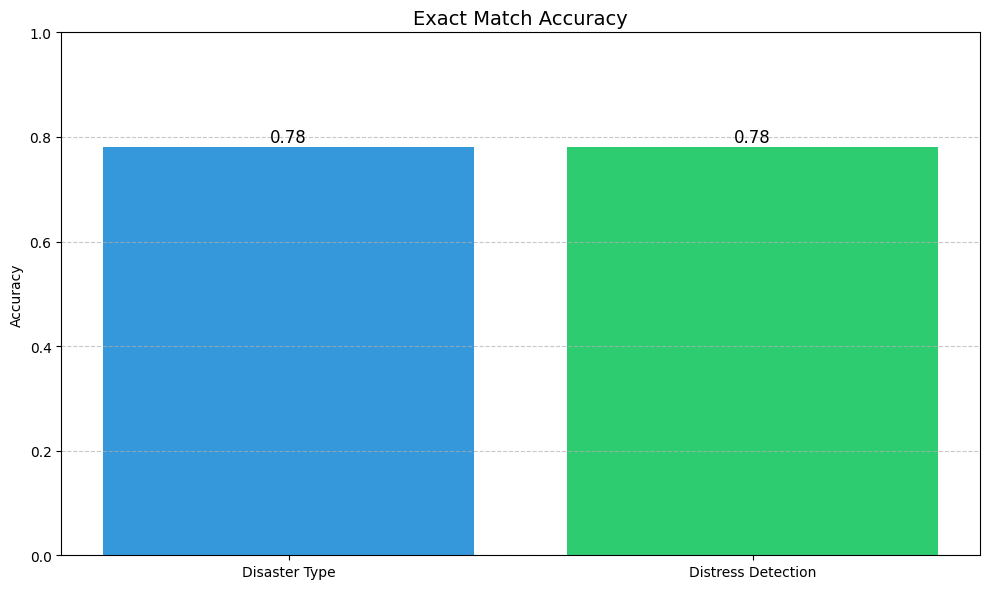

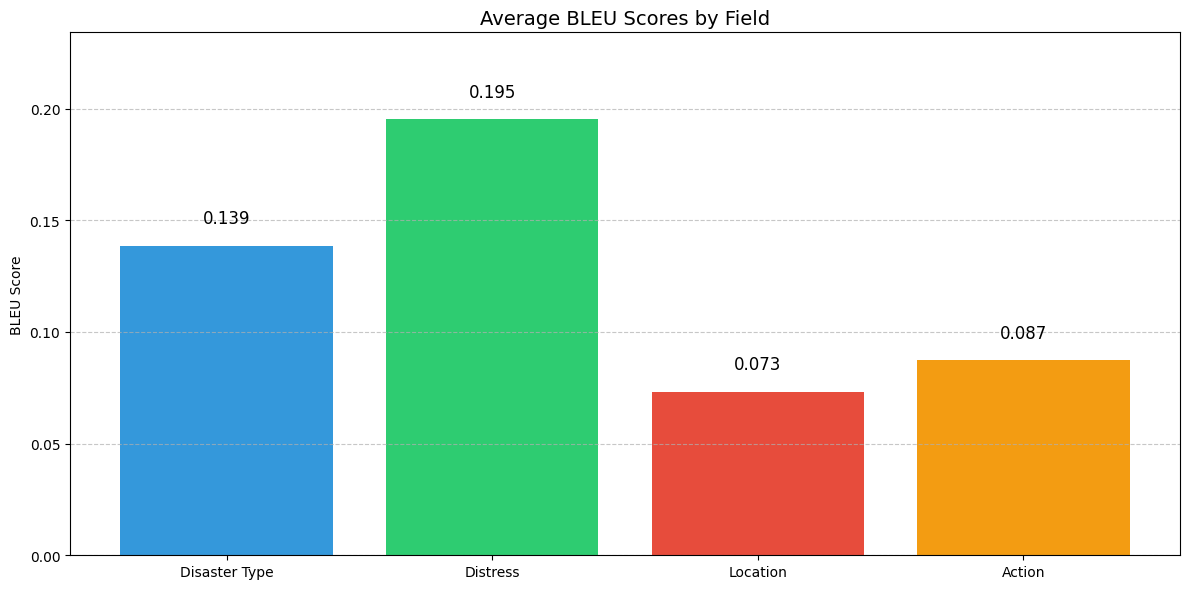

<Figure size 1200x600 with 0 Axes>

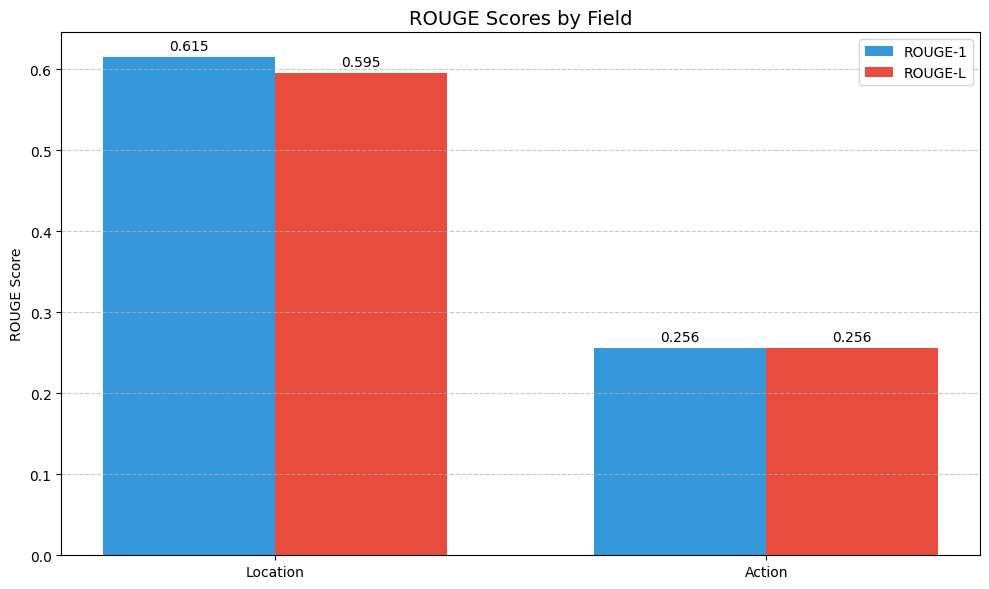

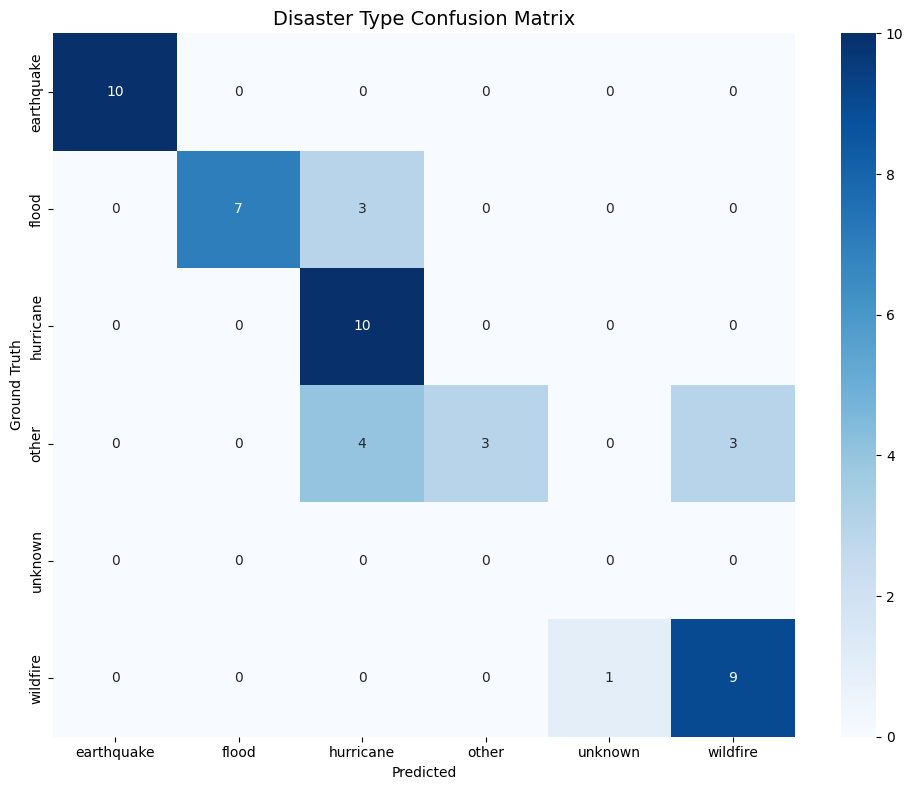

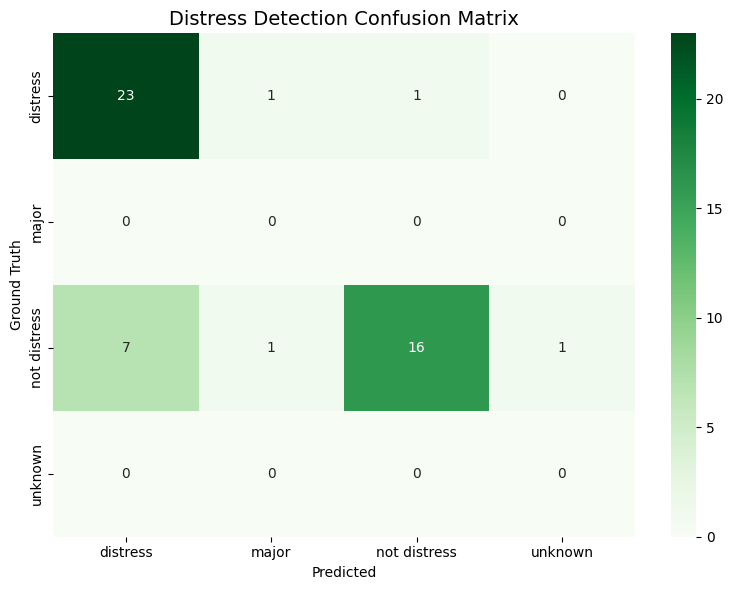


Disaster Type Classification Report:
              precision    recall  f1-score   support

  earthquake       1.00      1.00      1.00        10
       flood       1.00      0.70      0.82        10
   hurricane       0.59      1.00      0.74        10
       other       1.00      0.30      0.46        10
     unknown       0.00      0.00      0.00         0
    wildfire       0.75      0.90      0.82        10

    accuracy                           0.78        50
   macro avg       0.72      0.65      0.64        50
weighted avg       0.87      0.78      0.77        50


Distress Detection Classification Report:
              precision    recall  f1-score   support

    distress       0.77      0.92      0.84        25
       major       0.00      0.00      0.00         0
not distress       0.94      0.64      0.76        25
     unknown       0.00      0.00      0.00         0

    accuracy                           0.78        50
   macro avg       0.43      0.39      0.40       

C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [10]:
# Create evaluator with your existing RAG system
evaluator = RAGEvaluator(
    sample_dataset_path="sample_dataset_balanced.csv",
    rag_system=rag_system,  # Use your existing RAG system
    output_path="evaluation_results.csv"
)

# Run evaluation on the full dataset
results_df = evaluator.evaluate_all_samples()

# Get the aggregate metrics
metrics = evaluator.aggregate_metrics

# Visualize the results
visualize_results(results_df, metrics)

#  llama 7B quantized 

In [6]:
# path: llama2_rag.py

import faiss
import numpy as np
import pandas as pd
import torch
import re
import json
import time
import logging
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from typing import List, Dict, Any

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class EmergencyResponseRAG:
    def __init__(self, index_path="document_faiss.index", dataset_path="rest_dataset_with_document.csv",
                 embedding_model_name='all-mpnet-base-v2'):
        logger.info("Initializing Emergency Response RAG system (Llama2 7B Quantized)...")
        
        # 1. Load FAISS Index
        self.index = faiss.read_index(index_path)
        logger.info(f"Loaded FAISS index from {index_path}")
        
        # 2. Load Dataset
        self.df = pd.read_csv(dataset_path)
        logger.info(f"Loaded dataset from {dataset_path} with {len(self.df)} records")
        
        # 3. Load Embedding Model
        self.embedding_model = SentenceTransformer(embedding_model_name)
        logger.info(f"Loaded embedding model: {embedding_model_name}")
        
        # 4. Load Quantized Llama2-7B Model
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4"
        )
        self.tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", trust_remote_code=True)
        self.model = AutoModelForCausalLM.from_pretrained(
            "meta-llama/Llama-2-7b-chat-hf",
            quantization_config=quantization_config,
            device_map="auto",
            trust_remote_code=True
        )
        logger.info("Loaded Llama2-7B model (4-bit quantized) successfully.")

        # Valid outputs
        self.valid_disaster_types = ["wildfire", "earthquake", "flood", "hurricane", "other"]
        self.valid_distress_values = ["distress", "not distress"]
        self.valid_actions = ["evacuation", "medical aid", "fire suppression", "rescue", "resource delivery", "monitor only"]

    def clean_tweet(self, text: str) -> str:
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        text = re.sub(r'\@\w+', '', text)
        text = re.sub(r'#', '', text)
        text = text.encode('ascii', 'ignore').decode('ascii')
        text = text.lower()
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def embed_text(self, text: str) -> np.ndarray:
        embedding = self.embedding_model.encode([text], convert_to_numpy=True)
        return embedding

    def retrieve_documents(self, query: str, k: int = 3) -> List[str]:
        query_vector = self.embed_text(query)
        distances, indices = self.index.search(query_vector, k)
        if len(indices[0]) == 0 or (indices[0][0] == -1):
            logger.warning("No relevant documents found.")
            return ["No relevant incident reports available."]
        retrieved_docs = self.df.iloc[indices[0]]['document'].tolist()
        logger.info(f"Retrieved {len(retrieved_docs)} documents")
        return retrieved_docs

    def build_prompt(self, tweet_text: str, retrieved_docs: List[str]) -> str:
        """Constructs the prompt for Llama2"""
        prompt = f"""
You are an emergency response assistant. Analyze the tweet and related incidents.
Classify:
- Disaster Type: wildfire, earthquake, flood, hurricane, or other
- Distress: distress / not distress
- Location: most specific geographic location or unknown
- Action: evacuation, medical aid, fire suppression, rescue, resource delivery, or monitor only

Tweet:
{tweet_text}

Related Incidents:
"""
        for idx, doc in enumerate(retrieved_docs, 1):
            prompt += f"\nIncident {idx}: {doc}"

        prompt += """

Return your analysis strictly in this JSON format:
{
"disaster_type": "<disaster type>",
"distress": "<distress or not distress>",
"location_info": "<location or unknown>",
"action": "<selected action>"
}
"""
        return prompt

    def call_llama(self, tweet_text: str, retrieved_docs: List[str]) -> Dict[str, Any]:
        """Call Llama2 and parse the structured response"""
        try:
            full_prompt = self.build_prompt(tweet_text, retrieved_docs)
            inputs = self.tokenizer(full_prompt, return_tensors="pt").to(self.model.device)
            outputs = self.model.generate(**inputs, max_new_tokens=512, temperature=0.2)
            generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

            # Extract JSON
            json_start = generated_text.find("{")
            json_end = generated_text.rfind("}") + 1
            if json_start == -1 or json_end == -1:
                logger.error("Failed to extract JSON from Llama2 output.")
                return self._get_default_response()

            json_str = generated_text[json_start:json_end]
            result = json.loads(json_str)

            # Validation
            if result.get("disaster_type", "other").lower() not in self.valid_disaster_types:
                result["disaster_type"] = "other"
            if result.get("distress", "not distress").lower() not in self.valid_distress_values:
                result["distress"] = "distress"
            if result.get("action", "monitor only").lower() not in self.valid_actions:
                result["action"] = "monitor only"
            if "location_info" not in result:
                result["location_info"] = "unknown"

            return result
        
        except Exception as e:
            logger.error(f"Llama2 model error: {e}")
            return self._get_default_response()

    def _get_default_response(self) -> Dict[str, Any]:
        return {
            "disaster_type": "other",
            "distress": "not distress",
            "location_info": "unknown",
            "action": "monitor only"
        }

    def process_tweet(self, tweet_text: str) -> Dict[str, Any]:
        """Main pipeline"""
        try:
            cleaned_tweet = self.clean_tweet(tweet_text)
            retrieved_docs = self.retrieve_documents(cleaned_tweet)
            start_time = time.time()
            analysis = self.call_llama(cleaned_tweet, retrieved_docs)
            processing_time = time.time() - start_time
            logger.info(f"Processing time: {processing_time:.2f} seconds")
            return {
                "input_tweet": tweet_text,
                "cleaned_tweet": cleaned_tweet,
                "retrieved_docs": retrieved_docs,
                "analysis": analysis,
                "processing_time": processing_time
            }
        except Exception as e:
            logger.error(f"Error in process_tweet: {e}")
            return {
                "input_tweet": tweet_text,
                "error": str(e),
                "analysis": self._get_default_response()
            }

# Main execution
if __name__ == "__main__":
    print("Emergency Tweet Response System (RAG + Quantized Llama2 7B)")
    print("Type 'exit' to quit.\n")

    try:
        rag_system = EmergencyResponseRAG()

        while True:
            incoming_tweet = input("Enter a new tweet: ")
            if incoming_tweet.lower() == 'exit':
                break

            result = rag_system.process_tweet(incoming_tweet)

            print("\n=== Emergency Response Analysis ===")
            print(f"Tweet: {result['input_tweet']}")
            print("\nAnalysis:")
            analysis = result["analysis"]
            print(f"Disaster Type: {analysis['disaster_type']}")
            print(f"Distress Level: {analysis['distress']}")
            print(f"Location: {analysis['location_info']}")
            print(f"Recommended Action: {analysis['action']}")
            print(f"Processing Time: {result['processing_time']:.2f} seconds")
            print("=" * 50)

    except KeyboardInterrupt:
        print("\nExiting...")
    except Exception as e:
        print(f"\nAn error occurred: {e}")
    finally:
        print("\nSystem shutdown complete.")


2025-04-27 23:42:44,402 - INFO - Initializing Emergency Response RAG system (Llama2 7B Quantized)...
2025-04-27 23:42:44,422 - INFO - Loaded FAISS index from document_faiss.index
2025-04-27 23:42:44,534 - INFO - Loaded dataset from rest_dataset_with_document.csv with 18032 records
2025-04-27 23:42:44,561 - INFO - Use pytorch device_name: cuda:0
2025-04-27 23:42:44,561 - INFO - Load pretrained SentenceTransformer: all-mpnet-base-v2


Emergency Tweet Response System (RAG + Quantized Llama2 7B)
Type 'exit' to quit.



2025-04-27 23:42:46,229 - INFO - Loaded embedding model: all-mpnet-base-v2
2025-04-27 23:42:46,624 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2025-04-27 23:42:58,348 - INFO - Loaded Llama2-7B model (4-bit quantized) successfully.


Enter a new tweet:  testing bridges for safety after major hurricanes like irma


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:43:13,620 - INFO - Retrieved 3 documents
C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\integrations\sdpa_attention.py:54: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
2025-04-27 23:43:15,639 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:43:15,640 - INFO - Processing time: 2.02 seconds



=== Emergency Response Analysis ===
Tweet: testing bridges for safety after major hurricanes like irma

Analysis:
Disaster Type: other
Distress Level: not distress
Location: unknown
Recommended Action: monitor only
Processing Time: 2.02 seconds


Enter a new tweet:  in dominica hurricane maria killed 27 people and dozens are still missing


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:43:30,197 - INFO - Retrieved 3 documents
2025-04-27 23:43:31,968 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:43:31,968 - INFO - Processing time: 1.77 seconds



=== Emergency Response Analysis ===
Tweet: in dominica hurricane maria killed 27 people and dozens are still missing

Analysis:
Disaster Type: other
Distress Level: not distress
Location: unknown
Recommended Action: monitor only
Processing Time: 1.77 seconds


Enter a new tweet:  11 dead 100 injured wildfires ravage northern california with shocking speed


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:44:10,000 - INFO - Retrieved 3 documents
2025-04-27 23:44:11,071 - INFO - Processing time: 1.07 seconds



=== Emergency Response Analysis ===
Tweet: 11 dead 100 injured wildfires ravage northern california with shocking speed

Analysis:
Disaster Type: other
Distress Level: distress
Location: <location or unknown>
Recommended Action: monitor only
Processing Time: 1.07 seconds


Enter a new tweet:  labrador helping mexicos earthquake efforts earns presidential thanks


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:44:35,740 - INFO - Retrieved 3 documents
2025-04-27 23:44:36,657 - INFO - Processing time: 0.92 seconds



=== Emergency Response Analysis ===
Tweet: labrador helping mexicos earthquake efforts earns presidential thanks

Analysis:
Disaster Type: other
Distress Level: distress
Location: <location or unknown>
Recommended Action: monitor only
Processing Time: 0.92 seconds


Enter a new tweet:  exit



System shutdown complete.


In [9]:
# path: llama2_rag_evaluation_run.py

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time
import json
import logging
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from typing import Dict, List, Any

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Initialize Rouge scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

class RAGSystemEvaluator:
    def __init__(self, rag_system, sample_dataset_path="sample_dataset_balanced.csv", output_path="evaluation_results"):
        self.sample_df = pd.read_csv(sample_dataset_path)
        print(f"Loaded sample dataset from {sample_dataset_path} with {len(self.sample_df)} samples")

        self.rag_system = rag_system
        self.output_path = output_path
        self.smoothing = SmoothingFunction().method1
        self.results = []

    def calculate_bleu(self, reference: str, hypothesis: str) -> float:
        if not reference or not hypothesis:
            return 0.0
        return sentence_bleu(
            [reference.lower().split()],
            hypothesis.lower().split(),
            smoothing_function=self.smoothing
        )

    def calculate_rouge(self, reference: str, hypothesis: str) -> Dict[str, Dict[str, float]]:
        if not reference or not hypothesis or len(reference.strip()) == 0 or len(hypothesis.strip()) == 0:
            return {k: {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0} for k in ['rouge1', 'rouge2', 'rougeL']}
        try:
            scores = scorer.score(reference, hypothesis)
            return {k: {'precision': v.precision, 'recall': v.recall, 'fmeasure': v.fmeasure} for k, v in scores.items()}
        except:
            return {k: {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0} for k in ['rouge1', 'rouge2', 'rougeL']}

    def calculate_exact_match(self, reference: str, hypothesis: str) -> float:
        return 1.0 if reference.lower().strip() == hypothesis.lower().strip() else 0.0

    def evaluate_sample(self, row: pd.Series) -> Dict[str, Any]:
        tweet_text = row['tweet_text']

        gt_disaster_type = str(row['disaster_type']).lower() if not pd.isna(row['disaster_type']) else "unknown"
        gt_distress = "distress" if row['distress'] == 1 else "not distress"
        gt_location = str(row['state']).lower() if not pd.isna(row['state']) else "unknown"
        if not pd.isna(row['sub_location']) and str(row['sub_location']).strip():
            gt_location += f" ({str(row['sub_location']).lower()})"
        gt_action = str(row['take_action']).lower() if not pd.isna(row['take_action']) else "unknown"

        print(f"Processing: {tweet_text[:50]}...")
        start_time = time.time()
        prediction = self.rag_system.process_tweet(tweet_text)
        processing_time = time.time() - start_time

        pred_analysis = prediction['analysis']
        pred_disaster_type = str(pred_analysis['disaster_type']).lower()
        pred_distress = str(pred_analysis['distress']).lower()
        pred_location = str(pred_analysis['location_info']).lower()
        pred_action = str(pred_analysis['action']).lower()

        result = {
            'tweet_id': row.get('tweet_id', 'unknown'),
            'tweet_text': tweet_text,
            'gt_disaster_type': gt_disaster_type,
            'pred_disaster_type': pred_disaster_type,
            'disaster_type_bleu': self.calculate_bleu(gt_disaster_type, pred_disaster_type),
            'disaster_type_exact': self.calculate_exact_match(gt_disaster_type, pred_disaster_type),
            'gt_distress': gt_distress,
            'pred_distress': pred_distress,
            'distress_bleu': self.calculate_bleu(gt_distress, pred_distress),
            'distress_exact': self.calculate_exact_match(gt_distress, pred_distress),
            'gt_location': gt_location,
            'pred_location': pred_location,
            'location_bleu': self.calculate_bleu(gt_location, pred_location),
            'location_rouge_1': self.calculate_rouge(gt_location, pred_location)['rouge1']['fmeasure'],
            'location_rouge_2': self.calculate_rouge(gt_location, pred_location)['rouge2']['fmeasure'],
            'location_rouge_l': self.calculate_rouge(gt_location, pred_location)['rougeL']['fmeasure'],
            'gt_action': gt_action,
            'pred_action': pred_action,
            'action_bleu': self.calculate_bleu(gt_action, pred_action),
            'action_rouge_1': self.calculate_rouge(gt_action, pred_action)['rouge1']['fmeasure'],
            'action_rouge_2': self.calculate_rouge(gt_action, pred_action)['rouge2']['fmeasure'],
            'action_rouge_l': self.calculate_rouge(gt_action, pred_action)['rougeL']['fmeasure'],
            'processing_time': processing_time,
            'retrieved_docs': prediction.get('retrieved_docs', [])
        }

        print(f"Processed in {processing_time:.2f} seconds")
        return result

    def evaluate_all_samples(self):
        print(f"Starting evaluation of {len(self.sample_df)} samples...")
        for _, row in tqdm(self.sample_df.iterrows(), total=len(self.sample_df), desc="Evaluating"):
            try:
                result = self.evaluate_sample(row)
                self.results.append(result)
            except Exception as e:
                print(f"Error: {e}")

        return pd.DataFrame(self.results)

def run_comprehensive_evaluation(rag_system, output_prefix="llama2_quantized_evaluation"):
    evaluator = RAGSystemEvaluator(rag_system)
    results_df = evaluator.evaluate_all_samples()

    results_df.to_csv(f"{output_prefix}.csv", index=False)
    print(f"Saved results to {output_prefix}.csv")

    print("\nGenerating reports and plots...")
    disaster_report = classification_report(results_df['gt_disaster_type'], results_df['pred_disaster_type'])
    distress_report = classification_report(results_df['gt_distress'], results_df['pred_distress'])
    print("\n===== Disaster Type Classification Report =====")
    print(disaster_report)
    print("\n===== Distress Detection Classification Report =====")
    print(distress_report)

    disaster_cm = confusion_matrix(results_df['gt_disaster_type'], results_df['pred_disaster_type'])
    distress_cm = confusion_matrix(results_df['gt_distress'], results_df['pred_distress'])

    plt.figure(figsize=(12, 5))
    sns.heatmap(disaster_cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Disaster Type Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.heatmap(distress_cm, annot=True, fmt='d', cmap='Greens')
    plt.title('Distress Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.histplot(results_df['processing_time'], bins=20, kde=True)
    plt.title('Processing Time Distribution')
    plt.xlabel('Processing Time (seconds)')
    plt.ylabel('Frequency')
    plt.show()

    return results_df


2025-04-27 23:49:53,709 - INFO - Using default tokenizer.


Loaded sample dataset from sample_dataset_balanced.csv with 50 samples
Starting evaluation of 50 samples...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Processing: testing bridges for safety after major hurricanes ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:49:56,451 - INFO - Retrieved 3 documents
2025-04-27 23:49:57,503 - INFO - Processing time: 1.05 seconds


Processed in 1.11 seconds
Processing: why a navy hospital ship in puerto rico has hardly...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:49:57,518 - INFO - Retrieved 3 documents
2025-04-27 23:49:58,411 - INFO - Processing time: 0.89 seconds


Processed in 0.91 seconds
Processing: hurricane maria the aftermath st croix usvi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:49:58,428 - INFO - Retrieved 3 documents
2025-04-27 23:49:59,313 - INFO - Processing time: 0.88 seconds


Processed in 0.90 seconds
Processing: on wul helping those affected by #harvey via a ver...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:49:59,328 - INFO - Retrieved 3 documents
2025-04-27 23:50:00,245 - INFO - Processing time: 0.92 seconds


Processed in 0.93 seconds
Processing: hurricane maria path update shock spaghetti model ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:00,261 - INFO - Retrieved 3 documents
2025-04-27 23:50:01,601 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:50:01,602 - INFO - Processing time: 1.34 seconds


Processed in 1.36 seconds
Processing: our own rebecca newmanexcited to help in service p...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:01,616 - INFO - Retrieved 3 documents
2025-04-27 23:50:03,043 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:50:03,043 - INFO - Processing time: 1.43 seconds


Processed in 1.44 seconds
Processing: viking 41 sqn tornado gr4...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:03,059 - INFO - Retrieved 3 documents
2025-04-27 23:50:07,649 - INFO - Processing time: 4.59 seconds


Processed in 4.60 seconds
Processing: in dominica hurricane maria killed 27 people and d...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:07,664 - INFO - Retrieved 3 documents
2025-04-27 23:50:09,100 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:50:09,100 - INFO - Processing time: 1.43 seconds


Processed in 1.45 seconds
Processing: were here to help #irma #harvey...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:09,125 - INFO - Retrieved 3 documents
2025-04-27 23:50:10,119 - INFO - Processing time: 0.99 seconds


Processed in 1.02 seconds
Processing: our hearts go out to the victims of hurricane mari...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:10,135 - INFO - Retrieved 3 documents
2025-04-27 23:50:11,007 - INFO - Processing time: 0.87 seconds


Processed in 0.89 seconds
Processing: northern california wildfires deal crippling blow ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:11,024 - INFO - Retrieved 3 documents
2025-04-27 23:50:11,920 - INFO - Processing time: 0.90 seconds


Processed in 0.91 seconds
Processing: 14 images show devastation left behind by northern...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:11,937 - INFO - Retrieved 3 documents
2025-04-27 23:50:12,839 - INFO - Processing time: 0.90 seconds


Processed in 0.92 seconds
Processing: california wildfires watch as this family finds th...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:12,855 - INFO - Retrieved 3 documents
2025-04-27 23:50:13,641 - INFO - Processing time: 0.78 seconds


Processed in 0.80 seconds
Processing: teenage students help rescue animals escaping cali...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:13,657 - INFO - Retrieved 3 documents
2025-04-27 23:50:14,520 - INFO - Processing time: 0.86 seconds


Processed in 0.88 seconds
Processing: new #canyonfire2 in orange county california is no...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:14,536 - INFO - Retrieved 3 documents
2025-04-27 23:50:15,449 - INFO - Processing time: 0.91 seconds


Processed in 0.93 seconds
Processing: the home of #peanuts creator charles schulz has be...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:15,464 - INFO - Retrieved 3 documents
2025-04-27 23:50:16,230 - INFO - Processing time: 0.77 seconds


Processed in 0.78 seconds
Processing: an inferno like youve never seen deadly wildfires ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:16,247 - INFO - Retrieved 3 documents
2025-04-27 23:50:17,613 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:50:17,613 - INFO - Processing time: 1.37 seconds


Processed in 1.38 seconds
Processing: 11 dead 100 injured wildfires ravage northern cali...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:17,630 - INFO - Retrieved 3 documents
2025-04-27 23:50:18,512 - INFO - Processing time: 0.88 seconds


Processed in 0.90 seconds
Processing: 23 dead hundreds still missing in california as wi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:18,528 - INFO - Retrieved 3 documents
2025-04-27 23:50:19,912 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:50:19,913 - INFO - Processing time: 1.38 seconds


Processed in 1.40 seconds
Processing: many latinos are struggling in californias wildfir...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:19,930 - INFO - Retrieved 3 documents
2025-04-27 23:50:21,024 - INFO - Processing time: 1.09 seconds


Processed in 1.11 seconds
Processing: once again service dogs are a vital part of the re...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:21,041 - INFO - Retrieved 3 documents
2025-04-27 23:50:21,895 - INFO - Processing time: 0.85 seconds


Processed in 0.87 seconds
Processing: mexico earthquake praise for those who raced to he...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:21,911 - INFO - Retrieved 3 documents
2025-04-27 23:50:22,841 - INFO - Processing time: 0.93 seconds


Processed in 0.95 seconds
Processing: this is frida she has saved 52 people so far in me...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:22,856 - INFO - Retrieved 3 documents
2025-04-27 23:50:26,290 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:50:26,291 - INFO - Processing time: 3.43 seconds


Processed in 3.45 seconds
Processing: ioc voices readiness to help earthquakeaffected pe...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:26,307 - INFO - Retrieved 3 documents
2025-04-27 23:50:27,128 - INFO - Processing time: 0.82 seconds


Processed in 0.84 seconds
Processing: iran iraq earthquake concern over darbandikhandam...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:27,144 - INFO - Retrieved 3 documents
2025-04-27 23:50:28,609 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:50:28,609 - INFO - Processing time: 1.47 seconds


Processed in 1.48 seconds
Processing: mexico earthquake labased nonprofit cofem launches...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:28,625 - INFO - Retrieved 3 documents
2025-04-27 23:50:29,476 - INFO - Processing time: 0.85 seconds


Processed in 0.86 seconds
Processing: aaecho daily flash #mexicoearthquake situation upd...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:29,491 - INFO - Retrieved 3 documents
2025-04-27 23:50:32,177 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:50:32,178 - INFO - Processing time: 2.69 seconds


Processed in 2.70 seconds
Processing: labrador helping mexicos earthquake efforts earns ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:32,196 - INFO - Retrieved 3 documents
2025-04-27 23:50:33,046 - INFO - Processing time: 0.85 seconds


Processed in 0.87 seconds
Processing: 5 ways you can help mexico after the deadly earthq...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:33,062 - INFO - Retrieved 3 documents
2025-04-27 23:50:36,502 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:50:36,502 - INFO - Processing time: 3.44 seconds


Processed in 3.45 seconds
Processing: a devastating earthquake has claimed hundreds of l...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:36,520 - INFO - Retrieved 3 documents
2025-04-27 23:50:37,382 - INFO - Processing time: 0.86 seconds


Processed in 0.88 seconds
Processing: these are the peoples were affected by the flood #...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:37,400 - INFO - Retrieved 3 documents
2025-04-27 23:50:38,172 - INFO - Processing time: 0.77 seconds


Processed in 0.79 seconds
Processing: death toll in floodhit sri lanka hits 202 hospital...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:38,188 - INFO - Retrieved 3 documents
2025-04-27 23:50:39,085 - INFO - Processing time: 0.90 seconds


Processed in 0.91 seconds
Processing: dominica after hurricane maria trees stripped by w...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:39,102 - INFO - Retrieved 3 documents
2025-04-27 23:50:39,959 - INFO - Processing time: 0.86 seconds


Processed in 0.87 seconds
Processing: #srilanka appeals for help as #floods cripple wate...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:39,975 - INFO - Retrieved 3 documents
2025-04-27 23:50:40,717 - INFO - Processing time: 0.74 seconds


Processed in 0.76 seconds
Processing: #houston no flood insurance here are some resource...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:40,733 - INFO - Retrieved 3 documents
2025-04-27 23:50:41,647 - INFO - Processing time: 0.91 seconds


Processed in 0.93 seconds
Processing: irma inundated us and we need your help...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:41,662 - INFO - Retrieved 3 documents
2025-04-27 23:50:42,571 - INFO - Processing time: 0.91 seconds


Processed in 0.92 seconds
Processing: why floodedout cars are likely total losses #hurri...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:42,588 - INFO - Retrieved 3 documents
2025-04-27 23:50:43,423 - INFO - Processing time: 0.83 seconds


Processed in 0.85 seconds
Processing: helped to collect and send a leyland bus full of b...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:43,439 - INFO - Retrieved 3 documents
2025-04-27 23:50:46,810 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:50:46,810 - INFO - Processing time: 3.37 seconds


Processed in 3.39 seconds
Processing: tips on how you can help flood victims cope after ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:46,827 - INFO - Retrieved 3 documents
2025-04-27 23:50:47,670 - INFO - Processing time: 0.84 seconds


Processed in 0.86 seconds
Processing: hurricane irma may bring significant storm surge t...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:47,687 - INFO - Retrieved 3 documents
2025-04-27 23:50:48,495 - INFO - Processing time: 0.81 seconds


Processed in 0.82 seconds
Processing: houston refinery significantly underestimated amou...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:48,513 - INFO - Retrieved 3 documents
2025-04-27 23:50:49,352 - INFO - Processing time: 0.84 seconds


Processed in 0.86 seconds
Processing: there are no reasons us citizens cannot be helped...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:49,368 - INFO - Retrieved 3 documents
2025-04-27 23:50:50,789 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:50:50,790 - INFO - Processing time: 1.42 seconds


Processed in 1.44 seconds
Processing: i named it #cylon mora fucker 7...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:50,806 - INFO - Retrieved 3 documents
2025-04-27 23:50:51,704 - INFO - Processing time: 0.90 seconds


Processed in 0.91 seconds
Processing: big thanks to for sponsoring some of my silly draw...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:51,719 - INFO - Retrieved 3 documents
2025-04-27 23:50:54,374 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:50:54,374 - INFO - Processing time: 2.65 seconds


Processed in 2.67 seconds
Processing: retweeted kate mora cant have enough khan on #bwba...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:54,391 - INFO - Retrieved 3 documents
2025-04-27 23:50:55,308 - INFO - Processing time: 0.92 seconds


Processed in 0.93 seconds
Processing: sacramento business helping fire victims via...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:55,323 - INFO - Retrieved 3 documents
2025-04-27 23:50:56,809 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:50:56,810 - INFO - Processing time: 1.49 seconds


Processed in 1.50 seconds
Processing: why there is no magic formula to recovery after a ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:56,827 - INFO - Retrieved 3 documents
2025-04-27 23:50:58,220 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:50:58,220 - INFO - Processing time: 1.39 seconds


Processed in 1.41 seconds
Processing: texas families fear their land has been poisoned w...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:58,236 - INFO - Retrieved 3 documents
2025-04-27 23:50:59,202 - INFO - Processing time: 0.97 seconds


Processed in 0.98 seconds
Processing: #santarosa #fire #mendocino ave from kaiser #hospi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:50:59,217 - INFO - Retrieved 3 documents
2025-04-27 23:51:00,627 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:51:00,627 - INFO - Processing time: 1.41 seconds


Processed in 1.42 seconds
Processing: watch live vice president pence addresses puerto r...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-27 23:51:00,643 - INFO - Retrieved 3 documents
2025-04-27 23:51:02,017 - ERROR - Llama2 model error: Extra data: line 8 column 1 (char 155)
2025-04-27 23:51:02,017 - INFO - Processing time: 1.37 seconds


Processed in 1.39 seconds
Saved results to llama2_quantized_evaluation.csv

Generating reports and plots...

===== Disaster Type Classification Report =====
              precision    recall  f1-score   support

  earthquake       0.00      0.00      0.00        10
       flood       0.00      0.00      0.00        10
   hurricane       0.00      0.00      0.00        10
       other       0.20      1.00      0.33        10
    wildfire       0.00      0.00      0.00        10

    accuracy                           0.20        50
   macro avg       0.04      0.20      0.07        50
weighted avg       0.04      0.20      0.07        50


===== Distress Detection Classification Report =====
              precision    recall  f1-score   support

    distress       0.47      0.64      0.54        25
not distress       0.44      0.28      0.34        25

    accuracy                           0.46        50
   macro avg       0.45      0.46      0.44        50
weighted avg       0.45     

C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

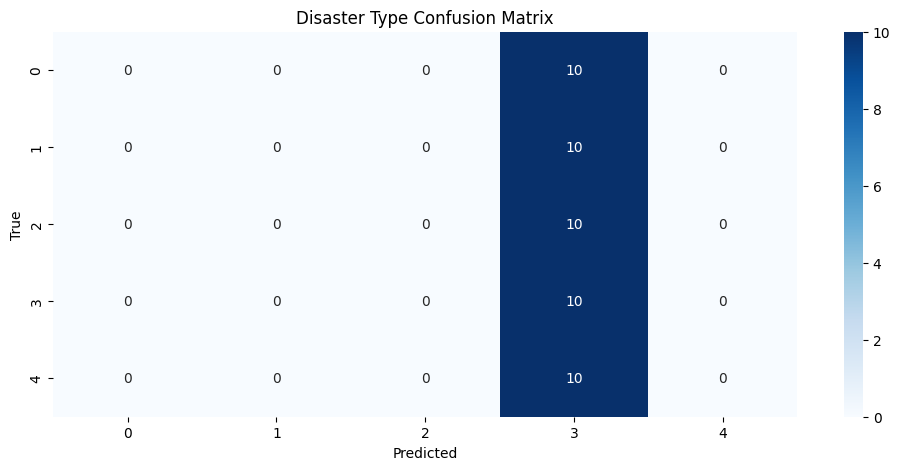

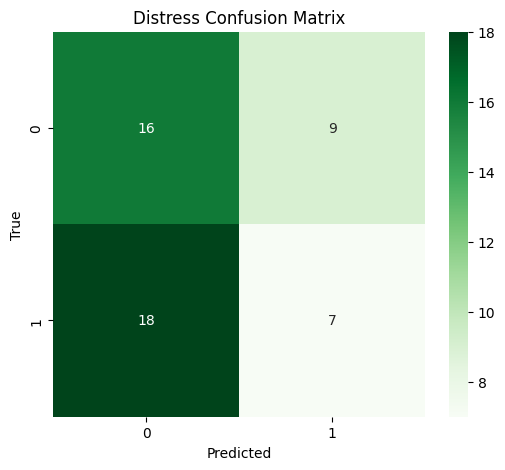

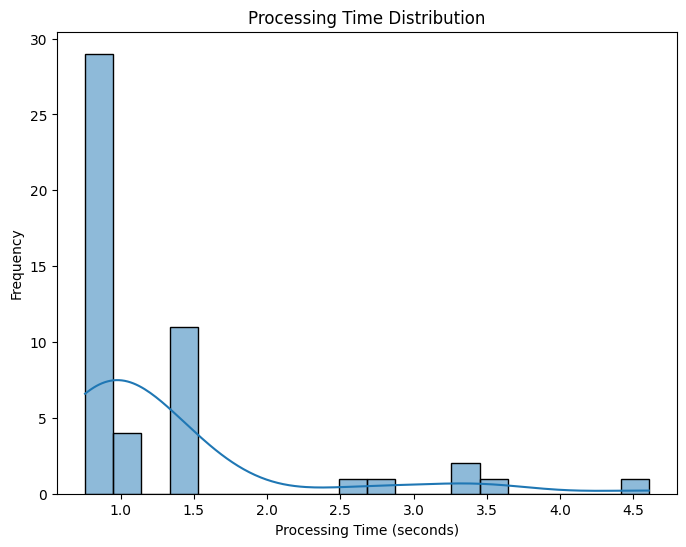

In [10]:
results_df = run_comprehensive_evaluation(rag_system, output_prefix="llama2_quantized_evaluation")